Now the big problem is: how to distinguish candy from background galaxies?

1. Calculate physical radius and stellar mass based on the associated host's redshift
2. Try to use Sersic $n$, $\mu_e / \mu_0$, etc.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os, sys
import dill, pickle
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row
from astropy.convolution import convolve, Gaussian2DKernel

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [27]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_cutout_cat_1103.fits')
meas_cat = Table.read('./Catalog/nsa_vanilla_sample_measurement_1103_success.fits')

In [48]:
jl_votes = Table.read('./Catalog/20hosts/LSBG_Zoo_jiaxuanl_2021_11_17_00_27_18.log', format='ascii')
jl_votes.rename_columns(jl_votes.colnames, ['name', 'gal', 'candy', 'junk'])
jl_votes['viz-id'] = [int(item.lstrip('nsa_')) for item in jl_votes['name']]
jl_votes.remove_column('name')
for key in ['gal', 'candy', 'junk']:
    jl_votes[key] = jl_votes[key].data.astype(bool)
    
jl_votes.sort('viz-id')

In [60]:
jg_votes = Table.read('./Catalog/20hosts/LSBG_Zoo_jgreene_2021_11_17_20_48_40.log', format='ascii')
jg_votes.rename_columns(jg_votes.colnames, ['name', 'gal', 'candy', 'junk'])
jg_votes['viz-id'] = [int(item.lstrip('nsa_')) for item in jg_votes['name']]
jg_votes.remove_column('name')
for key in ['gal', 'candy', 'junk']:
    jg_votes[key] = jg_votes[key].data.astype(bool)
    
jg_votes.sort('viz-id')

In [30]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

# color_bound = [0.1, 1.2]
# half_width = 0.25

# mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
#     (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
#     (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

# #mask &= (meas_cat['SB_0'][:, 2] > 21)
# mask &= (meas_cat['SB_eff_ellip'][:, 2] > 22)
# mask &= (meas_cat['C'] < 3.5)
# mask &= (meas_cat['rhalf_ellip'] > 2 / 0.168)

In [31]:
# lsbg_cat = lsbg_cat[mask]
# meas_cat = meas_cat[mask]

In [32]:
with open('./Catalog/hosts_nsa_z001_002_20hosts.pkl', 'rb') as f:
    host_cat = pickle.load(f)
host_z = np.zeros(len(meas_cat))
for i, lsbg in enumerate(meas_cat):
    ind = int(lsbg['ID'])
    _match = [host['Z'] for host in host_cat if ind in host['1vir_lsbg_idx']]
    if len(_match) > 1:
        print(f'More than one is matched for {i}:', _match)
    host_z[i] = _match[0]
meas_cat.add_column(Column(data=host_z, name='host_z'))

In [37]:
from astropy.cosmology import Planck15
cosmos = Planck15

In [38]:
ang_diam_dist = cosmos.angular_diameter_distance(meas_cat['host_z']).value # not consider peculiar motion
rhalf_phys = meas_cat['rhalf_circ'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
meas_cat['rhalf_circ_phys'] = rhalf_phys

rhalf_phys = meas_cat['r20'] * kz.HSC_pixel_scale / 206265 * ang_diam_dist * 1000 # kpc
meas_cat['r20_phys'] = rhalf_phys

#### Calcualte a mass. First calculate the absolute magnitude: $M = m + 25 + 5 * np.log10(D (Mpc))$

In [40]:
meas_cat['abs_mag'] = meas_cat['mag'] - 25 - 5 * np.log10(ang_diam_dist)[:, np.newaxis] # ugri

In [41]:
BV = 0.62 * (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 1]) + 0.15
V = meas_cat['mag'][:, 0] - 0.52 * (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 1]) - 0.03
V_abs = V - 25 - 5 * np.log10(ang_diam_dist)
log_ML_V = 1.493 * BV - 0.681
M = (4.83 - V_abs) / (2.5) + log_ML_V

In [43]:
meas_cat['log_m_star'] = M

In [147]:
if np.sum(meas_cat['ID'] != jl_votes['viz-id']) == 0:
    for key in ['gal', 'candy', 'junk']:
        meas_cat[key] = jg_votes[key]

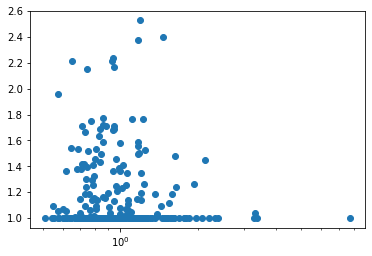

In [32]:
plt.scatter(meas_cat['rhalf_circ_phys'], meas_cat['sersic_n'])
plt.xscale('log')

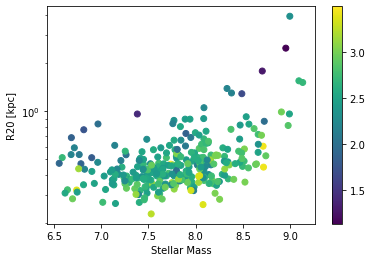

In [34]:
plt.scatter(M, meas_cat['r20_phys'], c=meas_cat['C'])

plt.yscale('log')

plt.xlabel('Stellar Mass')
plt.ylabel('R20 [kpc]')

plt.colorbar()

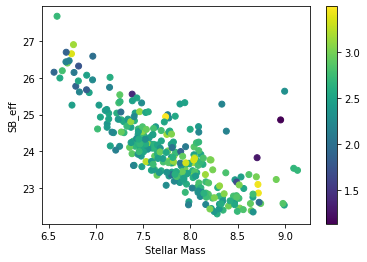

In [50]:
plt.scatter(M, meas_cat['SB_eff_circ'][:, 2], c=meas_cat['C'])


plt.xlabel('Stellar Mass')
plt.ylabel('SB_eff')

plt.colorbar()

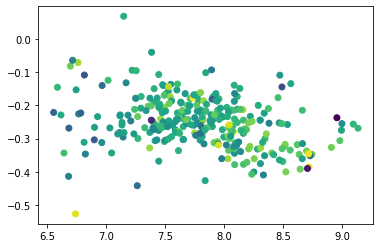

In [64]:
plt.scatter(M, meas_cat['SB_eff_circ'][:, 2] - meas_cat['SB_eff_circ'][:, 1], c=meas_cat['C'])

In [65]:
color = meas_cat['SB_eff_circ'][:, 2] - meas_cat['SB_eff_circ'][:, 1] # i - g

In [68]:
meas_cat['ID'][color < -0.3].data

array([ 1346.,  2154.,  2676.,  4150.,  4414.,  5794.,  8700., 13702.,
       13964., 14260., 14299., 17929., 18167., 19532., 22478., 22486.,
       23059., 23522., 23781., 24028., 24816., 26176., 27243., 28405.,
       32582., 35399., 36300., 42145., 42524., 43465., 45091., 45917.,
       46387., 46552., 46635., 47487., 50161., 50626., 50763., 51205.,
       52184., 52277., 52718., 53316., 56488., 57472., 57562., 60266.,
       63010., 64518., 65190., 67699., 68632., 69320., 70027., 70553.,
       71082., 71842., 72424., 72687., 73208., 73274., 74301., 74345.,
       75236., 76316., 77062., 77194., 79520., 81401., 84178., 85340.,
       86601., 86770., 88255.])

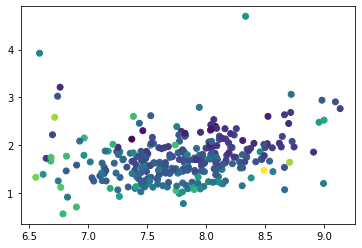

In [56]:
plt.scatter(M, meas_cat['SB_eff_circ'][:, 2] - meas_cat['SB_0'][:, 2], c=meas_cat['M20'])

### Analysis

In [68]:
import kuaizi
kuaizi.set_matplotlib(style='nature', usetex=False)

In [148]:
junk = meas_cat['junk']
candy = meas_cat['candy']
gal = meas_cat['gal']

In [149]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

In [150]:
print('Candy:', np.sum(candy))
print('Gal:', np.sum(gal))
print('Junk:', np.sum(junk))

Candy: 208
Gal: 138
Junk: 155


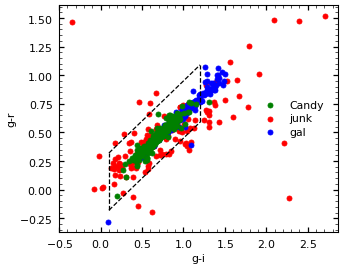

In [151]:
plt.scatter((g_mag - i_mag)[candy], (g_mag - r_mag)[candy], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk], (g_mag - r_mag)[junk], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal], (g_mag - r_mag)[gal], color='b', label='gal')

color_bound = [0.1, 1.2]
half_width = 0.25
plt.vlines(color_bound[0], 0.7 * color_bound[0] - half_width, 
           0.7 * color_bound[0] + half_width, color='k', ls='--')
plt.vlines(color_bound[1], 0.7 * color_bound[1] - half_width, 
           0.7 * color_bound[1] + half_width, color='k', ls='--')

x = np.linspace(color_bound[0], color_bound[1], 100)
plt.plot(x, 0.7 * x - half_width, color='k', ls='--')
plt.plot(x, 0.7 * x + half_width, color='k', ls='--')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

#plt.xlim(-0.5, 2.2)
#plt.ylim(-0.5, 2.2)

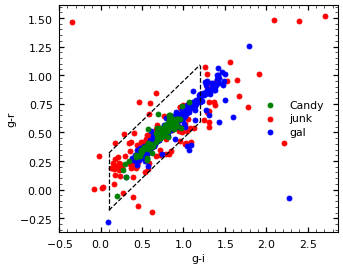

In [72]:
plt.scatter((g_mag - i_mag)[candy], (g_mag - r_mag)[candy], color='g', zorder=10, label='Candy')
plt.scatter((g_mag - i_mag)[junk], (g_mag - r_mag)[junk], color='r', label='junk')
plt.scatter((g_mag - i_mag)[gal], (g_mag - r_mag)[gal], color='b', label='gal')

color_bound = [0.1, 1.2]
half_width = 0.25
plt.vlines(color_bound[0], 0.7 * color_bound[0] - half_width, 
           0.7 * color_bound[0] + half_width, color='k', ls='--')
plt.vlines(color_bound[1], 0.7 * color_bound[1] - half_width, 
           0.7 * color_bound[1] + half_width, color='k', ls='--')

x = np.linspace(color_bound[0], color_bound[1], 100)
plt.plot(x, 0.7 * x - half_width, color='k', ls='--')
plt.plot(x, 0.7 * x + half_width, color='k', ls='--')

plt.xlabel('g-i')
plt.ylabel('g-r')

plt.legend()

#plt.xlim(-0.5, 2.2)
#plt.ylim(-0.5, 2.2)

Text(0, 0.5, 'SB_0_i')

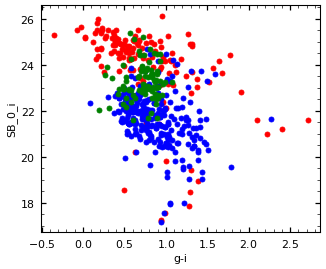

In [73]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['SB_0'][:, 2][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['SB_0'][:, 2][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['SB_0'][:, 2][gal], color='b')

plt.xlabel('g-i')
plt.ylabel('SB_0_i')

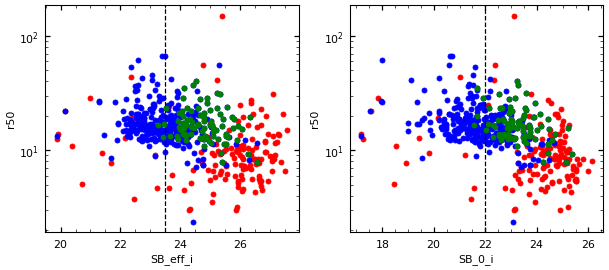

In [131]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 5))
plt.sca(ax1)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][candy ], meas_cat['rhalf_ellip'][candy ], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][junk ], meas_cat['rhalf_ellip'][junk ], color='r')
plt.scatter(meas_cat['SB_eff_ellip'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk ], color='b')

plt.axvline(23.5, color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

plt.sca(ax2)
plt.scatter(meas_cat['SB_0'][:, 2][candy ], meas_cat['rhalf_ellip'][candy ], color='g', zorder=10)
plt.scatter(meas_cat['SB_0'][:, 2][junk ], meas_cat['rhalf_ellip'][junk ], color='r')
plt.scatter(meas_cat['SB_0'][:, 2][~junk ], meas_cat['rhalf_ellip'][~junk ], color='b')

plt.axvline(22., color='k', ls='--')
plt.yscale('log')
plt.xlabel('SB_0_i')
plt.ylabel('r50')

plt.subplots_adjust(wspace=0.2)

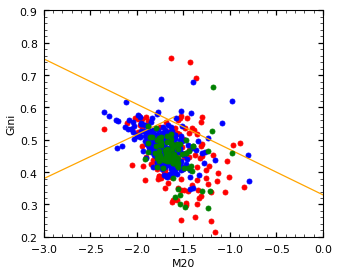

In [74]:
plt.scatter(meas_cat['M20'][candy], meas_cat['Gini'][candy], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk], meas_cat['Gini'][junk], color='r')
plt.scatter(meas_cat['M20'][gal], meas_cat['Gini'][gal], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

Text(0, 0.5, 'A')

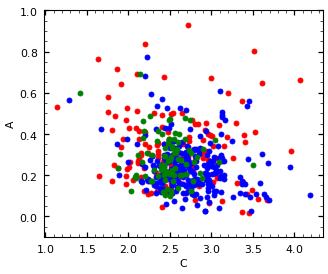

In [143]:
plt.scatter(meas_cat['C'][candy], meas_cat['A'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['A'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['A'][gal], color='b')

plt.ylim(-0.1, 1)
plt.xlabel('C')
plt.ylabel('A')

Text(0, 0.5, 'S')

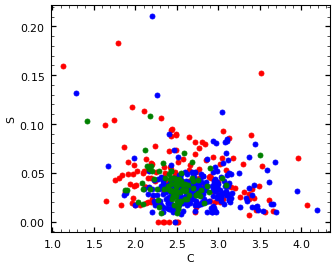

In [146]:
plt.scatter(meas_cat['C'][candy], meas_cat['S'][candy], color='g', zorder=10)
plt.scatter(meas_cat['C'][junk], meas_cat['S'][junk], color='r')
plt.scatter(meas_cat['C'][gal], meas_cat['S'][gal], color='b')

# plt.ylim(-1, 1)
plt.xlabel('C')
plt.ylabel('S')

Text(0, 0.5, 'r50 (pix)')

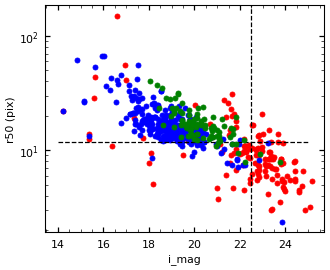

In [86]:
plt.scatter(i_mag[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter(i_mag[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(i_mag[gal], meas_cat['rhalf_ellip'][gal], color='b')
#plt.scatter(i_mag[223], meas_cat['rhalf_ellip'][223], color='yellow', marker='*', s=50, label='gal', zorder=10)


#plt.ylim(0, 1)
plt.hlines(2.0 / 0.168, 14, 25, color='k', ls='--')
plt.axvline(22.5, color='k', ls='--')
plt.yscale('log')
plt.xlabel('i_mag')
plt.ylabel('r50 (pix)')

(0.0, 30.0)

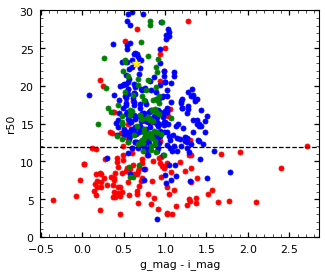

In [89]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')
plt.scatter((g_mag - i_mag)[327], meas_cat['rhalf_ellip'][327], color='yellow', marker='*', s=100, label='gal', zorder=10)

#plt.ylim(0, 1)
#plt.yscale('log')
plt.axhline(2.0 / 0.168, color='k', ls='--')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 30)

(0.0, 30.0)

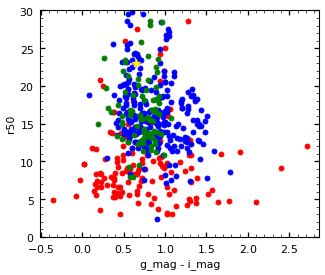

In [93]:
plt.scatter((g_mag - i_mag)[candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10)
plt.scatter((g_mag - i_mag)[junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter((g_mag - i_mag)[gal], meas_cat['rhalf_ellip'][gal], color='b')
plt.scatter((g_mag - i_mag)[327], meas_cat['rhalf_ellip'][327], color='yellow', marker='*', s=100, label='gal', zorder=10)

#plt.ylim(0, 1)
#plt.yscale('log')
plt.xlabel('g_mag - i_mag')
plt.ylabel('r50')

plt.ylim(0, 30)

In [139]:
color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['SB_0'][:, 2] > 22.0)
mask &= (meas_cat['SB_eff_ellip'][:, 2] > 23.5)

mask &= (meas_cat['C'] < 3.5)

mask &= (meas_cat['rhalf_ellip'] > 2 / 0.168)
print('Candy:', np.sum(mask & candy))
print('Gal:', np.sum(mask & gal))
print('Junk:', np.sum(mask & junk))

Candy: 74
Gal: 64
Junk: 16


Text(0, 0.5, 'S(G,M20)')

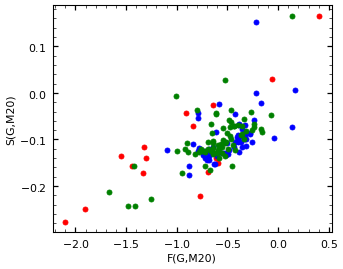

In [140]:
plt.scatter(meas_cat['F(G,M20)'][candy & mask], meas_cat['S(G,M20)'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['F(G,M20)'][junk & mask], meas_cat['S(G,M20)'][junk & mask], color='r')
plt.scatter(meas_cat['F(G,M20)'][gal & mask], meas_cat['S(G,M20)'][gal & mask], color='b')

plt.xlabel('F(G,M20)')
plt.ylabel('S(G,M20)')

Text(0, 0.5, 'Bulge statistics F(G,M20)')

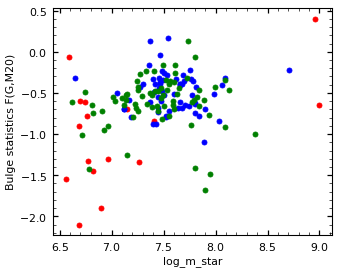

In [141]:
plt.scatter(meas_cat['log_m_star'][candy & mask], meas_cat['F(G,M20)'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['log_m_star'][junk & mask], meas_cat['F(G,M20)'][junk & mask], color='r')
plt.scatter(meas_cat['log_m_star'][gal & mask], meas_cat['F(G,M20)'][gal & mask], color='b')

plt.xlabel('log_m_star')
plt.ylabel('Bulge statistics F(G,M20)')

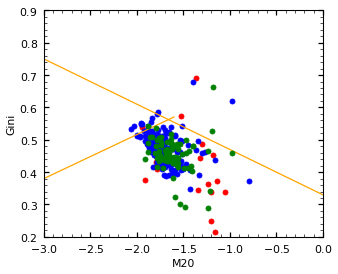

In [95]:
plt.scatter(meas_cat['M20'][candy & mask], meas_cat['Gini'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['M20'][junk & mask], meas_cat['Gini'][junk & mask], color='r')
plt.scatter(meas_cat['M20'][gal & mask], meas_cat['Gini'][gal & mask], color='b')

plt.xlabel('M20')
plt.ylabel('Gini')

plt.xlim(-3, 0)
plt.ylim(0.2, 0.9)

x = np.linspace(-3, 0, 10)
plt.plot(x, -0.14 * x + 0.33, color='orange')
x = np.linspace(-3, -1.6, 10)
plt.plot(x, 0.136 * x + 0.788, color='orange')

In [ ]:
## SB_gi_0 - SB_gi_e v.s. R_eff

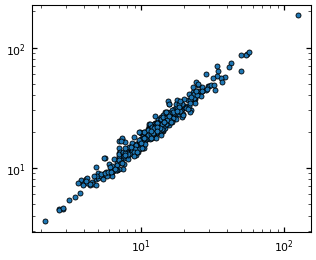

In [116]:
plt.scatter(meas_cat['r50'], meas_cat['r80'])
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'r50')

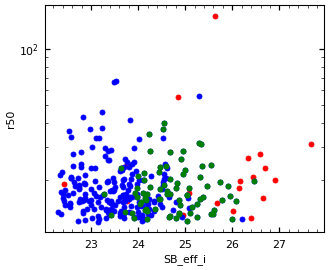

In [117]:
plt.scatter(meas_cat['SB_eff_circ'][:, 2][candy & mask], meas_cat['rhalf_ellip'][candy & mask], color='g', zorder=10)
plt.scatter(meas_cat['SB_eff_circ'][:, 2][junk & mask], meas_cat['rhalf_ellip'][junk & mask], color='r')
plt.scatter(meas_cat['SB_eff_circ'][:, 2][~junk & mask], meas_cat['rhalf_ellip'][~junk & mask], color='b')

#plt.ylim(0, 1)
plt.yscale('log')
plt.xlabel('SB_eff_i')
plt.ylabel('r50')

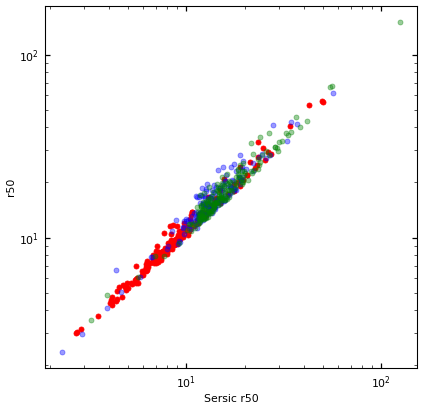

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(meas_cat['rhalf_circ'][candy], meas_cat['rhalf_ellip'][candy], color='g', zorder=10, alpha=.4)
plt.scatter(meas_cat['rhalf_circ'][junk], meas_cat['rhalf_ellip'][junk], color='r')
plt.scatter(meas_cat['rhalf_circ'][gal], meas_cat['rhalf_ellip'][gal], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('Sersic r50')
plt.ylabel('r50')
plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, 'r50 / r20')

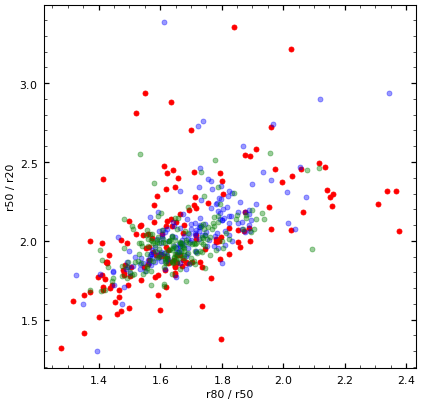

In [35]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(meas_cat['r80'][candy] / meas_cat['r50'][candy], 
            meas_cat['r50'][candy] / meas_cat['r20'][candy], color='g', zorder=10, alpha=.4)

plt.scatter(meas_cat['r80'][junk] / meas_cat['r50'][junk], 
            meas_cat['r50'][junk] / meas_cat['r20'][junk], color='r')

plt.scatter(meas_cat['r80'][gal] / meas_cat['r50'][gal], 
            meas_cat['r50'][gal] / meas_cat['r20'][gal], color='b', alpha=0.4)

# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(-5, 100)
#plt.ylim(-5, 100)

plt.xlabel('r80 / r50')
plt.ylabel('r50 / r20')

In [79]:
lsbg_cat[mask].write('./Catalog/nsa_20hosts_sample_211103_visual_inspect.fits', overwrite=True)

In [110]:
1.5 / (50 * 1000) * 206265

6.18795